### Reproducing results

In Zhong 2007, the following synthetic data is described as having been used for testing: 

40 sequences of length T=200, generated from two continuous HMM models (HMM1, HMM2), 20 from each. The number of hidden states is 2 from both models. The prior and observation parameters for HMM1 and HMM2 are the same. The prior is uniform and the observation distribution is univariate Gaussian with mean $\mu = 3$ and variance $\sigma^2 = 1$ for hidden state 1, and $\mu = 0$ with variance $\sigma^2 = 1$ for hidden state 2. The state transition parameters are A1 = [[0.6, 0.4],[0.4, 0.6]] and A2 = [[0.4, 0.6],[0.6, 0.4]] respectively.

Each experiment (for labelled 2-12 labelled sequences) was run 20 times, reporting the average classification error. They found that increasing the number of hidden states used to model the data from 2 to 5 improved the accuracy.

In [1]:
%matplotlib inline

import random
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from hmmlearn.hmm import GaussianHMM

from sshmm import SemiSupervisedHMM

from sklearn.metrics import classification_report, f1_score, accuracy_score

import warnings

#### Function to generate the mock data

In [2]:
def mock_data(n_samples, n_total, n_labelled, class_split, seed, startprob, means, covars, transmat):

    n_unlabelled = n_total-n_labelled
    model0 = GaussianHMM(n_components=2, covariance_type="diagonal")
    model0.startprob_ = startprob[0]
    model0.means_ = means[0]
    model0.covars_ = covars[0]
    model0.transmat_ = transmat[0]

    model1 = GaussianHMM(n_components=2, covariance_type="diagonal")
    model1.startprob_ = startprob[1]
    model1.means_ = means[1]
    model1.covars_ = covars[1]
    model1.transmat_ = transmat[1]

    n0 = int(n_labelled*class_split)
    n1 = int(n_labelled*(1-class_split))

    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        X = []
        Y = []
        X_t = []
        Y_t = []
        for i in range(0, int(n_total*class_split)):
            x,_ = model0.sample(n_samples)
            xt,_ = model0.sample(n_samples)

            X = np.append(X, x)
            X_t = np.append(X_t, xt)

        for i in range(0, int(n_total*(1-class_split))):
            y,_ = model1.sample(n_samples)
            yt,_ = model1.sample(n_samples)
            Y = np.append(Y, y)
            Y_t = np.append(Y_t, yt)

    seq_labelled = np.append(X[:n_samples*n0], Y[:n_samples*n1])
    seq_unlabelled = np.append(X[n_samples*n0:],Y[n_samples*n1:])
    
    seq_labelled_len = np.ones(n_labelled)*n_samples
    seq_unlabelled_len = np.ones(n_unlabelled)*n_samples
    
    seq_labelled_class = np.append(np.zeros(n_labelled/2), np.ones(n_labelled/2))
    seq_unlabelled_class = np.append(np.zeros(n_unlabelled/2), np.ones(n_unlabelled/2))
    
    seq_test = np.append(X_t, Y_t)
    seq_test_class = np.append(np.zeros(n_total/2), np.ones(n_total/2))
    seq_test_len = np.ones(n_total)*n_samples
    
    return seq_labelled, seq_unlabelled, seq_labelled_len, \
seq_unlabelled_len, seq_labelled_class, seq_unlabelled_class, \
seq_test, seq_test_class, seq_test_len

#### Generate some data

In [3]:
is_semisupervised = True
n_samples = 200
n_total = 40
class_split = 0.5
seed = 11

startprob =  [np.array([0.5, 0.5]), np.array([0.5, 0.5])]
means = [np.array([[3],[0]]), np.array([[3],[0]])]
covars = [np.array([[1], [1]]), np.array([[1], [1]])]
transmat = [np.array([[0.6, 0.4],[0.4, 0.6]]), np.array([[0.4, 0.6],[0.6, 0.4]])]

o = []

for i in range(0,20):
    t = []
    for n_labelled in range(2, 14, 2):

        seq_labelled, seq_unlabelled, seq_labelled_len, seq_unlabelled_len, \
        seq_labelled_class, seq_unlabelled_class, seq_test, seq_test_class, \
        seq_test_len = mock_data(n_samples, n_total, n_labelled, class_split, seed+i, startprob, means, covars, transmat)

        sshmm2 = SemiSupervisedHMM(seq_labelled, seq_unlabelled, seq_labelled_len, seq_unlabelled_len, seq_labelled_class, np.array([2,2]), is_semisupervised)
        hmm2 = SemiSupervisedHMM(seq_labelled, seq_unlabelled, seq_labelled_len, seq_unlabelled_len, seq_labelled_class, np.array([2,2]), False)
        sshmm5 = SemiSupervisedHMM(seq_labelled, seq_unlabelled, seq_labelled_len, seq_unlabelled_len, seq_labelled_class, np.array([5,5]), is_semisupervised)
        hmm5 = SemiSupervisedHMM(seq_labelled, seq_unlabelled, seq_labelled_len, seq_unlabelled_len, seq_labelled_class, np.array([5,5]), False)

        import warnings
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=DeprecationWarning)
            
            sshmm2.run()
            hmm2.run()
            sshmm5.run()
            hmm5.run()

        o.append({
            'n':n_labelled, 
            'SSHC-1 (2-state)':1-accuracy_score(sshmm2.lbl_u, seq_unlabelled_class), 
            'HMM(2-state)':1-accuracy_score(hmm2.lbl_u, seq_unlabelled_class), 
            'SSHC-1 (5-state)':1-accuracy_score(sshmm5.lbl_u, seq_unlabelled_class), 
            'HMM(5-state)':1-accuracy_score(hmm5.lbl_u, seq_unlabelled_class)})

In [4]:
df = pd.DataFrame(o)
df = df.groupby('n').mean()

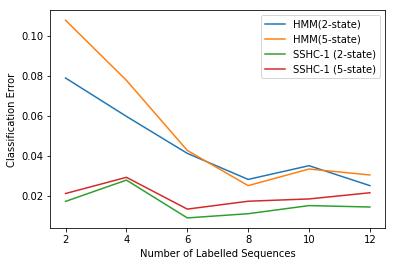

In [5]:
_ = df.plot()
_ = plt.xlabel('Number of Labelled Sequences')
_ = plt.ylabel('Classification Error')

### Conclusion

By and large the data matches observations found in the paper, although classification errrors for both the supervised (HMM) and the semi-supervised (SSHC-1) cases are about half what was reported, and there does not appear to be any benefit in a 5-state model, contrary to the findings in the paper but in line with the theory.